# Dimensions vs. LLM: A Comparative Analysis of Bibliographic Knowledge

This notebook provides a complete, reproducible framework for comparing structured bibliographic data sourced from two distinct origins:

- **Dimensions** — a comprehensive research information database, queried via the `dimcli` API, treated as the ground truth.
- **OpenAI LLM** — a large language model queried to fill in the same fields for the same list of publications.

The notebook is organised into the following sections:

| Section | Description |
|---|---|
| **1. Imports** | All library imports in one place |
| **2. Configuration** | File paths, model selection, random seed, sample size |
| **3. Functions** | All reusable functions (Dimensions, LLM, evaluation, ML) |
| **4. Data Acquisition** | Fetch from Dimensions and LLM, with disk caching |
| **5. Classical Evaluation** | TP/FP/FN/TN metrics with DOI validation |
| **6. ML Technique 1** | Semantic similarity scoring via sentence embeddings |
| **7. ML Technique 2** | Hallucination probability classifier |
| **8. Interpretation** | Summary of findings |

> **Caching**: All expensive operations (Dimensions queries, OpenAI calls, ML scores) are cached to `.pkl` files in the `cache/` directory. Re-running any cell will load from cache instead of re-executing the operation.

## 1. Imports

All required libraries are imported here. Install missing packages with:
```bash
pip install dimcli openai pandas requests numpy matplotlib scikit-learn
# For ML Techniques 1 & 2 (requires PyTorch):
pip install sentence-transformers torch
```

In [1]:
import os
import re
import json
import time
import pickle
import random
import requests
import numpy as np
import pandas as pd
import dimcli
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from functools import wraps
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
from openai import OpenAI
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sentence_transformers import SentenceTransformer, util as st_util
ST_AVAILABLE = True
pd.options.mode.chained_assignment = None

## 2. Configuration

Set the API key file paths, model, sample size, and cache paths here. All other cells read from these variables.

**Sample distribution (n=50):**

| Type | Count | Rationale |
|---|---|---|
| Articles | 30 | Most common publication type |
| Proceedings chapters | 10 | Conference contributions |
| Books | 10 | Co-authored monographs only |
| **Total** | **50** | Minimum for reliable statistical analysis |

In [2]:
# ── API Key settings ─────────────────────────────────────────────────────
DIMENSIONS_KEY_FILE = 'key.txt'
OPENAI_KEY_FILE     = 'openai_key.txt'

# ── Dimensions query settings ─────────────────────────────────────────────
RANDOM_SEED  = 42
N_ARTICLES   = 30
N_BOOKS      = 10
N_CHAPTERS   = 10
N_TOTAL      = N_ARTICLES + N_BOOKS + N_CHAPTERS

# ── OpenAI settings ───────────────────────────────────────────────────────
LLM_MODEL   = 'gpt-4.1-mini'
MAX_RETRIES = 3
RETRY_DELAY = 5

# ── Cache file paths ──────────────────────────────────────────────────────
CACHE_DIR        = 'cache'
os.makedirs(CACHE_DIR, exist_ok=True)
CACHE_DIMENSIONS = f'{CACHE_DIR}/cache_dimensions_{N_TOTAL}.pkl'
CACHE_LLM        = f'{CACHE_DIR}/cache_llm_{N_TOTAL}.pkl'
CACHE_EVAL       = f'{CACHE_DIR}/cache_eval_{N_TOTAL}.pkl'
CACHE_SEMANTIC   = f'{CACHE_DIR}/cache_semantic_{N_TOTAL}.pkl'
CACHE_CLASSIFIER = f'{CACHE_DIR}/cache_classifier_{N_TOTAL}.pkl'

# ── Sentence transformer model ────────────────────────────────────────────
ST_MODEL_NAME = 'all-MiniLM-L6-v2'

print(f'Configuration: n={N_TOTAL} ({N_ARTICLES} articles, {N_BOOKS} books, {N_CHAPTERS} chapters), model={LLM_MODEL}')

Configuration: n=50 (30 articles, 10 books, 10 chapters), model=gpt-4.1-mini


## 3. Functions

All reusable functions are defined here, grouped into five subsections:

- **3.1 Caching utilities** — decorator-based disk caching for DataFrames and Python objects
- **3.2 Dimensions query functions** — fetch and normalise bibliographic data via `dimcli`
- **3.3 LLM (OpenAI) query functions** — query OpenAI for all 7 fields per paper
- **3.4 Evaluation functions** — TP/FP/FN/TN classification, DOI validation, citation similarity
- **3.5 ML functions** — semantic similarity scoring and hallucination classifier

In [3]:
# ════════════════════════════════════════════════════════════════════════
# 3.1  CACHING UTILITIES
# ════════════════════════════════════════════════════════════════════════

def cache_df(cache_path):
    """Decorator: cache a function that returns a DataFrame to a .pkl file."""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            if os.path.exists(cache_path):
                print(f'[CACHE] Loading from {cache_path}')
                return pd.read_pickle(cache_path)
            result = func(*args, **kwargs)
            result.to_pickle(cache_path)
            return result
        return wrapper
    return decorator


def cache_object(cache_path):
    """Decorator: cache any Python object to a .pkl file."""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            if os.path.exists(cache_path):
                print(f'[CACHE] Loading from {cache_path}')
                with open(cache_path, 'rb') as f:
                    return pickle.load(f)
            result = func(*args, **kwargs)
            with open(cache_path, 'wb') as f:
                pickle.dump(result, f)
            return result
        return wrapper
    return decorator

In [4]:
# ════════════════════════════════════════════════════════════════════════
# 3.2  DIMENSIONS QUERY FUNCTIONS
# ════════════════════════════════════════════════════════════════════════

def _login_dimensions(key_file):
    """Authenticate with Dimensions API using a plain API key from a text file."""
    if not os.path.exists(key_file):
        raise FileNotFoundError(f'Dimensions API key file not found: {key_file}')
    with open(key_file, 'r') as f:
        key = f.read().strip()
    dimcli.login(key=key, endpoint='https://app.dimensions.ai')
    return dimcli.Dsl()


def _fetch_type(dsl, pub_type, maxlimit=500, extra_filter=''):
    """
    Fetch COVID-19 publications of a given type with times_cited in [10:20].
    extra_filter: optional DSL filter clause (e.g. 'and book_series_title is empty').
    NOTE: limit/skip must NOT appear in the query string for query_iterative.
    """
    q = (
        'search publications '
        'in title_abstract_only for "COVID-19" '
        'where year > 2019 '
        'and times_cited in [10:20] '
        f'and type = "{pub_type}" '
        f'{extra_filter} '
        'return publications'
        '[id+authors+title+year+date+doi+type+times_cited+concepts+category_for]'
    )
    return dsl.query_iterative(q, maxlimit=maxlimit, verbose=False).as_dataframe()


def _fetch_citations(dsl, pub_id):
    """Fetch all papers that cite pub_id; return as list of dicts."""
    q = (
        f'search publications where reference_ids = "{pub_id}" '
        'return publications[title+year+doi] limit 1000'
    )
    try:
        df = dsl.query(q).as_dataframe()
        if df.empty:
            return []
        records = []
        for _, r in df.iterrows():
            records.append({
                'citation_title': str(r.get('title', '') or ''),
                'citation_year':  int(r['year']) if pd.notna(r.get('year')) else None,
                'citation_doi':   str(r.get('doi', '') or ''),
            })
        return records
    except Exception:
        return []


def _norm_authors(authors):
    """Return list of 'Last, First' strings."""
    if not isinstance(authors, list):
        return []
    result = []
    for a in authors:
        last  = str(a.get('last_name',  '') or '').strip()
        first = str(a.get('first_name', '') or '').strip()
        result.append(f'{last}, {first}' if last else first)
    return result


def _norm_concepts(concepts):
    """Return top-5 concept names by relevance."""
    if not concepts or not isinstance(concepts, list):
        return []
    clean_concepts = [c for c in concepts if isinstance(c, dict)]
    if not clean_concepts:
        return [str(c) for c in concepts[:5] if c]
    ranked = sorted(clean_concepts, key=lambda x: x.get('relevance', 0), reverse=True)
    return [c.get('concept', '') for c in ranked[:5] if c.get('concept')]


def _norm_categories(categories):
    """Strip leading numeric codes from category names."""
    if not isinstance(categories, list):
        return []
    return [re.sub(r'^\\d+\\s*[-.]?\\s*', '', c.get('name', '')).strip()
            for c in categories if isinstance(c, dict) and c.get('name')]


@cache_df(CACHE_DIMENSIONS)
def get_bibliographic_data(key_file, seed, n_articles, n_books, n_chapters):
    """
    Fetch n=50 COVID-19 publications from Dimensions:
      - n_articles  articles  (times_cited in [10:20])
      - n_books     books     (co-authored monographs, not collected volumes)
      - n_chapters  chapters  (proceedings/conference papers)
    Returns a DataFrame with 10 columns:
      author_names, title, year, date, doi, type,
      main_concepts, research_areas, time_cited, cited_by
    """
    dsl = _login_dimensions(key_file)
    random.seed(seed)

    print('Fetching articles...')
    art_df = _fetch_type(dsl, 'article', maxlimit=500)
    print(f'  {len(art_df)} articles found')

    print('Fetching books...')
    book_df = _fetch_type(dsl, 'book', maxlimit=200, extra_filter='and book_series_title is empty')
    print(f'  {len(book_df)} books found')

    print('Fetching proceedings chapters...')
    chap_df = _fetch_type(dsl, 'chapter', maxlimit=200)
    # Keep only chapters that look like conference proceedings
    if 'source_title' in chap_df.columns:
        mask = chap_df['source_title'].str.contains(
            r'proceeding|conference|symposium|workshop', case=False, na=False
        )
        chap_df = chap_df[mask]
    print(f'  {len(chap_df)} proceedings chapters found')

    # Random selection with fixed seed
    sel_art  = random.sample(art_df['id'].tolist(),  min(n_articles, len(art_df)))
    sel_book = random.sample(book_df['id'].tolist(), min(n_books,    len(book_df)))
    sel_chap = random.sample(chap_df['id'].tolist(), min(n_chapters, len(chap_df)))
    selected_ids = sel_art + sel_book + sel_chap

    all_df = pd.concat([art_df, book_df, chap_df]).drop_duplicates(subset='id')
    df = all_df[all_df['id'].isin(selected_ids)].copy().reset_index(drop=True)

    # Normalise columns
    df['author_names']   = df['authors'].apply(_norm_authors)
    df['main_concepts']  = df['concepts'].apply(_norm_concepts)
    df['research_areas'] = df['category_for'].apply(_norm_categories)
    df['time_cited']     = pd.to_numeric(df['times_cited'], errors='coerce').fillna(0).astype(int)
    df['date']           = pd.to_datetime(df['date'], errors='coerce')
    df['year']           = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype(int)
    df['doi']            = df['doi'].fillna('').astype(str)
    df['type']           = df['type'].fillna('').astype(str)

    # Fetch citations
    print('Fetching citations for each publication...')
    df['cited_by'] = df['id'].apply(
        lambda pid: _fetch_citations(dsl, pid)
    )

    # Final column selection
    return df[['author_names', 'title', 'year', 'date', 'doi', 'type',
               'main_concepts', 'research_areas', 'time_cited', 'cited_by']]

In [5]:
# ════════════════════════════════════════════════════════════════════════
# 3.3  LLM (OPENAI) QUERY FUNCTIONS
# ════════════════════════════════════════════════════════════════════════

def _get_openai_client(key_file):
    """Initialise OpenAI client from a plain-text key file."""
    if not os.path.exists(key_file):
        raise FileNotFoundError(f'OpenAI API key file not found: {key_file}')
    with open(key_file, 'r') as f:
        key = f.read().strip()
    return OpenAI(api_key=key)


def _query_paper(client, paper_str, model, retries, delay):
    """
    Query OpenAI for 7 bibliographic fields for a single paper.
    paper_str: e.g. 'Brown, John and Smith, Mary, \'Title\' (2021)'
    Returns a dict with keys: date, doi, type, main_concepts,
                               research_areas, time_cited, cited_by
    """
    system_msg = (
        'You are a bibliographic expert. '
        'Given a paper reference, return a JSON object with exactly these keys:\n'
        '  "date"           – release date as YYYY-MM-DD string\n'
        '  "doi"            – DOI string (without https://doi.org/ prefix)\n'
        '  "type"           – publication type (article / book / chapter)\n'
        '  "main_concepts"  – list of top 5 concept strings\n'
        '  "research_areas" – list of research area strings (no leading numbers)\n'
        '  "time_cited"     – integer citation count\n'
        '  "cited_by"       – list of up to 20 dicts, each with keys '
        '"citation_title", "citation_year", "citation_doi"\n'
        'Return ONLY the JSON object. No markdown, no code fences, no extra text.'
    )
    for attempt in range(1, retries + 1):
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[
                    {'role': 'system', 'content': system_msg},
                    {'role': 'user',   'content': paper_str},
                ],
                temperature=0,
            )
            raw = resp.choices[0].message.content.strip()
            raw = re.sub(r'^```[a-z]*\n?', '', raw)
            raw = re.sub(r'\n?```$', '', raw.strip())
            return json.loads(raw)
        except Exception as e:
            print(f'  [LLM] Attempt {attempt} failed: {e}')
            if attempt < retries:
                time.sleep(delay)
    return {}


@cache_df(CACHE_LLM)
def get_llm_data(bibliographic_df, key_file, model, retries, delay, verbose=True):
    """
    For each paper in bibliographic_df, build a 'paper' string from
    author_names + title + year, then query OpenAI for all 7 fields.
    Returns a DataFrame with columns:
      title, year, date, doi, type, main_concepts,
      research_areas, time_cited, cited_by
    """
    client = _get_openai_client(key_file)
    results = []
    total = len(bibliographic_df)
    for i, row in bibliographic_df.iterrows():
        # Build the paper reference string
        authors_str = ' and '.join(row['author_names']) if row['author_names'] else 'Unknown'
        paper_str = f"{authors_str}, '{row['title']}' ({row['year']})"
        if verbose:
            print(f'  [{i+1}/{total}] {paper_str[:80]}...')
        llm = _query_paper(client, paper_str, model, retries, delay)
        # Normalise types
        llm['title']          = row['title']
        llm['year']           = row['year']
        llm['date']           = str(llm.get('date', '') or '')
        llm['doi']            = str(llm.get('doi', '') or '')
        llm['type']           = str(llm.get('type', '') or '')
        llm['main_concepts']  = llm.get('main_concepts', []) or []
        llm['research_areas'] = llm.get('research_areas', []) or []
        llm['time_cited']     = int(llm['time_cited']) if str(llm.get('time_cited', '')).isdigit() else 0
        llm['cited_by']       = llm.get('cited_by', []) or []
        results.append(llm)
    df = pd.DataFrame(results)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    return df[['title', 'year', 'date', 'doi', 'type',
               'main_concepts', 'research_areas', 'time_cited', 'cited_by']]

In [6]:
# ════════════════════════════════════════════════════════════════════════
# 3.4  EVALUATION FUNCTIONS
# ════════════════════════════════════════════════════════════════════════
#
# Taxonomy:
#   TP  — LLM value matches Dimensions value
#   FP  — LLM has a value, Dimensions does not (or they disagree)
#   FN  — Dimensions has a value, LLM does not
#   TN  — Both are empty
#
# For 'doi' field: LLM DOIs are additionally validated via HTTP HEAD request
#   FP-valid    — LLM DOI resolves but differs from Dimensions DOI
#   FP-broken   — LLM DOI does not resolve (hallucination)
#
# For 'cited_by': comparison across three dimensions:
#   title similarity (sentence embeddings), year match, DOI validation

EVAL_SCALAR_COLS = ['date', 'doi', 'type', 'time_cited']
EVAL_SET_COLS    = ['main_concepts', 'research_areas']


def _check_doi_url(doi):
    """Check if a DOI resolves. Returns 'valid', 'broken', or 'empty'."""
    if not doi or not str(doi).strip():
        return 'empty'
    try:
        r = requests.head(f'https://doi.org/{doi}', allow_redirects=True, timeout=5)
        return 'valid' if r.status_code < 400 else f'broken ({r.status_code})'
    except Exception:
        return 'error'


def _fuzzy_match(a, b):
    """Token-overlap fuzzy match (Jaccard >= 0.6)."""
    if not a or not b:
        return False
    ta = set(re.split(r'[\s\-,]+', str(a).lower()))
    tb = set(re.split(r'[\s\-,]+', str(b).lower()))
    if not ta or not tb:
        return False
    return len(ta & tb) / len(ta | tb) >= 0.6


def _classify_scalar(dim_val, llm_val):
    has_d = bool(str(dim_val or '').strip())
    has_l = bool(str(llm_val or '').strip())
    if has_d and has_l and _fuzzy_match(dim_val, llm_val):
        return {'TP': 1, 'FP': 0, 'FN': 0, 'TN': 0}
    if has_l and not has_d:
        return {'TP': 0, 'FP': 1, 'FN': 0, 'TN': 0}
    if has_d and not has_l:
        return {'TP': 0, 'FP': 0, 'FN': 1, 'TN': 0}
    if has_d and has_l:
        return {'TP': 0, 'FP': 1, 'FN': 1, 'TN': 0}
    return {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 1}


def _classify_set(dim_list, llm_list):
    s_d = {str(x).strip().lower() for x in (dim_list or []) if x}
    s_l = {str(x).strip().lower() for x in (llm_list or []) if x}
    tp = sum(1 for l in s_l if any(_fuzzy_match(l, d) for d in s_d))
    fp = sum(1 for l in s_l if not any(_fuzzy_match(l, d) for d in s_d))
    fn = sum(1 for d in s_d if not any(_fuzzy_match(d, l) for l in s_l))
    tn = 1 if not s_d and not s_l else 0
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn}


def _score_citations(dim_cits, llm_cits, st_model):
    """
    Compare citation lists across three dimensions:
      1. Title similarity  (sentence-transformer cosine similarity)
      2. Year match        (exact, ±0)
      3. DOI validation    (HTTP HEAD on each LLM DOI)
    Returns a dict of summary statistics.
    """
    if not dim_cits and not llm_cits:
        return {'n_dim': 0, 'n_llm': 0, 'title_sim': None,
                'year_match_pct': None, 'doi_valid_pct': None}
    n_dim = len(dim_cits)
    n_llm = len(llm_cits)

    # 1. Title similarity
    title_sim = None
    if st_model and dim_cits and llm_cits:
        dt = [c.get('citation_title', '') for c in dim_cits]
        lt = [c.get('citation_title', '') for c in llm_cits]
        e_d = st_model.encode(dt)
        e_l = st_model.encode(lt)
        sims = st_util.cos_sim(e_l, e_d)
        title_sim = float(sims.max(axis=1).values.mean())

    # 2. Year match
    dim_years = {c.get('citation_year') for c in dim_cits if c.get('citation_year')}
    year_matches = sum(
        1 for c in llm_cits if c.get('citation_year') in dim_years
    )
    year_match_pct = year_matches / n_llm if n_llm else None

    # 3. DOI validation
    doi_statuses = [_check_doi_url(c.get('citation_doi', '')) for c in llm_cits]
    doi_valid_pct = sum(1 for s in doi_statuses if s == 'valid') / n_llm if n_llm else None

    return {
        'n_dim': n_dim, 'n_llm': n_llm,
        'title_sim': title_sim,
        'year_match_pct': year_match_pct,
        'doi_valid_pct': doi_valid_pct,
    }


def evaluate(dimensions_df, llm_df, verbose=True):
    """
    Compare llm_df against dimensions_df column by column.
    Returns (summary_df, citation_df, matplotlib_figure).
    """
    merged = dimensions_df.merge(llm_df, on='title', how='inner', suffixes=('_dim', '_llm'))
    n = len(merged)
    if verbose:
        print(f'Dimensions: {len(dimensions_df)} rows | LLM: {len(llm_df)} rows | Matched: {n}')

    # Load sentence transformer if available
    st_model = SentenceTransformer(ST_MODEL_NAME) if ST_AVAILABLE else None

    # ── Scalar + set evaluation ──────────────────────────────────────────
    summary_rows = []
    for col in EVAL_SCALAR_COLS + EVAL_SET_COLS:
        w_col = f'{col}_dim' if f'{col}_dim' in merged.columns else col
        l_col = f'{col}_llm' if f'{col}_llm' in merged.columns else col
        is_set = col in EVAL_SET_COLS
        totals = {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0}
        if verbose:
            print(f'  Evaluating: {col}')
        for _, row in merged.iterrows():
            counts = (_classify_set if is_set else _classify_scalar)(
                row.get(w_col), row.get(l_col)
            )
            for k in totals:
                totals[k] += counts[k]
        tp, fp, fn, tn = totals['TP'], totals['FP'], totals['FN'], totals['TN']
        P  = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        R  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        F1 = 2 * P * R / (P + R) if (P + R) > 0 else 0.0
        Ac = (tp + tn) / (tp + tn + fp + fn) if n > 0 else 0.0
        summary_rows.append({
            'column': col, 'type': 'set' if is_set else 'scalar',
            'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn,
            'Precision': round(P, 3), 'Recall': round(R, 3),
            'F1': round(F1, 3), 'Accuracy': round(Ac, 3),
        })

    summary = pd.DataFrame(summary_rows).set_index('column')

    # ── DOI validation for the 'doi' column ──────────────────────────────
    if verbose:
        print('  Validating LLM DOIs...')
    doi_col = 'doi_llm' if 'doi_llm' in merged.columns else 'doi'
    merged['doi_status'] = merged[doi_col].apply(_check_doi_url)

    # ── Citation comparison ───────────────────────────────────────────────
    if verbose:
        print('  Scoring citation similarity...')
    cited_col_d = 'cited_by_dim' if 'cited_by_dim' in merged.columns else 'cited_by'
    cited_col_l = 'cited_by_llm' if 'cited_by_llm' in merged.columns else 'cited_by'
    citation_rows = []
    for _, row in merged.iterrows():
        stats = _score_citations(row.get(cited_col_d, []), row.get(cited_col_l, []), st_model)
        stats['title'] = row['title']
        citation_rows.append(stats)
    citation_df = pd.DataFrame(citation_rows)

    # ── Plots ─────────────────────────────────────────────────────────────
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle(
        f'LLM vs Dimensions — Bibliographic Evaluation ({n} matched publications)',
        fontsize=14, fontweight='bold', y=0.98
    )
    gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.45, wspace=0.35)
    cols_list = list(summary.index)
    x = np.arange(len(cols_list))
    w = 0.55

    # Plot 1: Stacked TP/FP/FN/TN counts
    ax1 = fig.add_subplot(gs[0, 0])
    tp_v = summary['TP'].values
    fp_v = summary['FP'].values
    fn_v = summary['FN'].values
    tn_v = summary['TN'].values
    ax1.bar(x, tp_v, w, label='TP', color='#2ecc71')
    ax1.bar(x, fp_v, w, bottom=tp_v, label='FP', color='#e74c3c')
    ax1.bar(x, fn_v, w, bottom=tp_v + fp_v, label='FN', color='#e67e22')
    ax1.bar(x, tn_v, w, bottom=tp_v + fp_v + fn_v, label='TN', color='#95a5a6')
    ax1.set_xticks(x)
    ax1.set_xticklabels(cols_list, rotation=25, ha='right', fontsize=9)
    ax1.set_title('TP / FP / FN / TN Counts')
    ax1.set_ylabel('Count')
    ax1.legend(loc='upper right', fontsize=8)

    # Plot 2: Grouped Precision / Recall / F1 / Accuracy
    ax2 = fig.add_subplot(gs[0, 1])
    metrics  = ['Precision', 'Recall', 'F1', 'Accuracy']
    mcolors  = ['#9b59b6', '#1abc9c', '#f39c12', '#2980b9']
    bw = 0.18
    offs = np.linspace(-(len(metrics) - 1) / 2, (len(metrics) - 1) / 2, len(metrics)) * bw
    for j, (m, c) in enumerate(zip(metrics, mcolors)):
        ax2.bar(x + offs[j], summary[m].values, bw, label=m, color=c, alpha=0.85)
    ax2.set_xticks(x)
    ax2.set_xticklabels(cols_list, rotation=25, ha='right', fontsize=9)
    ax2.set_ylim(0, 1.15)
    ax2.set_title('Precision / Recall / F1 / Accuracy')
    ax2.axhline(1.0, color='grey', linewidth=0.7, linestyle='--')
    ax2.legend(fontsize=8)

    # Plot 3: Metric heatmap
    ax3 = fig.add_subplot(gs[1, 0])
    heat_m = metrics
    heat_d = summary[heat_m].values.astype(float)
    cmap = LinearSegmentedColormap.from_list('rg', ['#e74c3c', '#f39c12', '#2ecc71'])
    im = ax3.imshow(heat_d.T, aspect='auto', cmap=cmap, vmin=0, vmax=1)
    ax3.set_xticks(range(len(cols_list)))
    ax3.set_xticklabels(cols_list, rotation=25, ha='right', fontsize=9)
    ax3.set_yticks(range(len(heat_m)))
    ax3.set_yticklabels(heat_m, fontsize=8)
    ax3.set_title('Metric Heatmap')
    for i in range(len(heat_m)):
        for j in range(len(cols_list)):
            ax3.text(j, i, f'{heat_d[j, i]:.2f}', ha='center', va='center',
                     fontsize=7.5, color='black' if heat_d[j, i] > 0.4 else 'white')
    plt.colorbar(im, ax=ax3, fraction=0.03, pad=0.04)

    # Plot 4: DOI validation breakdown
    ax4 = fig.add_subplot(gs[1, 1])
    doi_counts = merged['doi_status'].value_counts()
    doi_colors = {'valid': '#2ecc71', 'empty': '#95a5a6',
                  'error': '#e67e22'}
    bar_colors = [doi_colors.get(k.split(' ')[0], '#e74c3c') for k in doi_counts.index]
    ax4.bar(range(len(doi_counts)), doi_counts.values, color=bar_colors)
    ax4.set_xticks(range(len(doi_counts)))
    ax4.set_xticklabels(doi_counts.index, rotation=25, ha='right', fontsize=9)
    ax4.set_title('LLM DOI Validation Status')
    ax4.set_ylabel('Count')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return summary, citation_df, fig

In [7]:
# ════════════════════════════════════════════════════════════════════════
# 3.5  ML FUNCTIONS
# ════════════════════════════════════════════════════════════════════════

ML_SCALAR_COLS = ['date', 'doi', 'type', 'time_cited']
ML_SET_COLS    = ['main_concepts', 'research_areas']


def score_semantic_similarity(dimensions_df, llm_df, verbose=True):
    """
    Technique 1: Compute semantic similarity (0.0–1.0) for each field
    using sentence-transformer embeddings and cosine similarity.
    Returns a DataFrame with one score per paper per column.
    """
    if not ST_AVAILABLE:
        print('[SKIP] sentence-transformers not installed.')
        return None
    if os.path.exists(CACHE_SEMANTIC):
        print(f'[CACHE] Loading from {CACHE_SEMANTIC}')
        return pd.read_pickle(CACHE_SEMANTIC)
    if verbose:
        print(f'Loading model: {ST_MODEL_NAME}...')
    model = SentenceTransformer(ST_MODEL_NAME)
    merged = dimensions_df.merge(llm_df, on='title', how='inner', suffixes=('_dim', '_llm'))
    if verbose:
        print(f'Computing scores for {len(merged)} publications...')
    results = []
    for i, row in merged.iterrows():
        scores = {'title': row['title']}
        for col in ML_SCALAR_COLS + ML_SET_COLS:
            wv = str(row.get(f'{col}_dim', '') or '')
            lv = str(row.get(f'{col}_llm', '') or '')
            if col in ML_SCALAR_COLS:
                if not wv.strip() or not lv.strip():
                    scores[col] = 1.0 if wv.strip().lower() == lv.strip().lower() else 0.0
                else:
                    e_w = model.encode(wv.strip().lower())
                    e_l = model.encode(lv.strip().lower())
                    scores[col] = float((st_util.cos_sim(e_w, e_l).item() + 1) / 2)
            else:
                sw = {x.strip().lower() for x in str(wv).split(',') if x.strip()}
                sl = {x.strip().lower() for x in str(lv).split(',') if x.strip()}
                if not sw and not sl:
                    scores[col] = 1.0
                elif not sw or not sl:
                    scores[col] = 0.0
                else:
                    ew = model.encode(list(sw))
                    el = model.encode(list(sl))
                    sims = st_util.cos_sim(el, ew)
                    scores[col] = float(sims.max(axis=1).values.mean())
        results.append(scores)
    sim_df = pd.DataFrame(results)
    sim_df.to_pickle(CACHE_SEMANTIC)
    return sim_df


def train_hallucination_classifier(dimensions_df, llm_df, verbose=True):
    """
    Technique 2: Train a logistic regression classifier to predict the
    probability that an LLM-generated cell value is a hallucination.
    Features: semantic_similarity, is_set_field, dim_value_exists, llm_value_length.
    Label: 1 if semantic_similarity < 0.5 and LLM has value but Dimensions does not.
    Returns (trained_model, feature_df).
    """
    if not ST_AVAILABLE:
        print('[SKIP] sentence-transformers not installed.')
        return None, None
    if os.path.exists(CACHE_CLASSIFIER):
        print(f'[CACHE] Loading from {CACHE_CLASSIFIER}')
        with open(CACHE_CLASSIFIER, 'rb') as f:
            return pickle.load(f)
    if verbose:
        print('Step 1: Computing semantic similarity scores...')
    sim_df = score_semantic_similarity(dimensions_df, llm_df, verbose=False)
    if sim_df is None:
        return None, None
    merged = dimensions_df.merge(llm_df, on='title', how='inner', suffixes=('_dim', '_llm'))
    features = []
    for _, row in sim_df.iterrows():
        title = row['title']
        m_row = merged[merged['title'] == title]
        if m_row.empty:
            continue
        m_row = m_row.iloc[0]
        for col in ML_SCALAR_COLS + ML_SET_COLS:
            wv = str(m_row.get(f'{col}_dim', '') or '')
            lv = str(m_row.get(f'{col}_llm', '') or '')
            sim = float(row.get(col, 0.0))
            features.append({
                'title':               title,
                'column':              col,
                'semantic_similarity': sim,
                'is_set_field':        int(col in ML_SET_COLS),
                'dim_value_exists':    int(bool(wv.strip())),
                'llm_value_length':    len(lv.strip()),
                'is_hallucination':    int(sim < 0.5 and bool(lv.strip()) and not bool(wv.strip())),
            })
    feat_df = pd.DataFrame(features)
    X = feat_df[['semantic_similarity', 'is_set_field', 'dim_value_exists', 'llm_value_length']]
    y = feat_df['is_hallucination']
    if len(y.unique()) < 2:
        if verbose:
            print('Not enough classes to train classifier.')
        return None, feat_df
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    if verbose:
        print(f'Step 2: Training on {len(X_tr)} samples, testing on {len(X_te)}...')
    clf = LogisticRegression(class_weight='balanced', max_iter=500)
    clf.fit(X_tr, y_tr)
    if verbose:
        y_pred = clf.predict(X_te)
        y_prob = clf.predict_proba(X_te)[:, 1]
        print('\n--- Classification Report ---')
        print(classification_report(y_te, y_pred))
        print(f'AUC: {roc_auc_score(y_te, y_prob):.3f}')
        coef = pd.DataFrame(clf.coef_[0], index=X.columns, columns=['Coefficient'])
        print('\n--- Feature Coefficients ---')
        print(coef.sort_values('Coefficient', ascending=False).to_string())
    feat_df['hallucination_probability'] = clf.predict_proba(X)[:, 1]
    result = (clf, feat_df)
    with open(CACHE_CLASSIFIER, 'wb') as f:
        pickle.dump(result, f)
    return result

## 4. Data Acquisition

We now fetch the two DataFrames. Both are cached to disk — subsequent runs load from cache instantly without making any network requests.

- **Dimensions** is queried via `dimcli` for 50 COVID-19 publications (30 articles, 10 books, 10 proceedings chapters) with `times_cited` in [10, 20], using a fixed random seed (`RANDOM_SEED = 42`) for reproducibility.
- **LLM** receives, for each paper, a reference string of the form `"Author1 and Author2, 'Title' (Year)"` and is asked to fill in all 7 fields.

In [8]:
# ── Dimensions DataFrame ─────────────────────────────────────────────────
bibliographic_df = get_bibliographic_data(
    DIMENSIONS_KEY_FILE, RANDOM_SEED, N_ARTICLES, N_BOOKS, N_CHAPTERS
)
print(f'\nDimensions DataFrame: {bibliographic_df.shape[0]} publications, '
      f'{bibliographic_df.shape[1]} columns')
display(bibliographic_df[['author_names', 'title', 'year', 'type', 'time_cited']].head(10))

[CACHE] Loading from cache/cache_dimensions_50.pkl

Dimensions DataFrame: 50 publications, 10 columns


,author_names,title,year,type,time_cited
0,"[Zhang, Hanyu, Zhou, Zengyuan]",Association of gut microbiota and dietary comp...,2023,article,10
1,"[Zheng, Chen, Huang, Wendy Ya-Jun, Sun, Feng-H...",Association of Sedentary Lifestyle with Risk o...,2023,article,14
2,"[Ghasemiyeh, Parisa, Mohammadi-Samani, Soliman]",Lessons we learned during the past four challe...,2024,article,12
3,"[Skarbinski, Jacek, Elkin, Eric P., Ziemba, Yo...",COVID-19 Vaccine Booster Uptake and Effectiven...,2025,article,10
4,"[da Cunha Sobieray, Narcizo Leopoldo Eduardo, ...",HELLP syndrome and COVID-19: A minor revision ...,2023,article,10
5,"[Gu, Jienan, Liu, Qianhui, Zhang, Jiale, Xu, S...",COVID-19 and trained immunity: the inflammator...,2023,article,18
6,"[Li, Jing-Xing, Wei, James Cheng-Chung, Wang, ...",RETINAL VASCULAR OCCLUSION AND COVID-19 DIAGNOSIS,2024,article,11
7,"[Franklin, David, Barbre, Kira, Rowe, Theresa ...","COVID-19 Vaccination Coverage, and Rates of SA...",2024,article,10
8,"[Liu, Ting-Hui, Huang, Po-Yu, Wu, Jheng-Yan, C...",Post-COVID-19 condition risk in patients with ...,2023,article,11
9,"[Reis, Stefanie, Faske, Amon, Monsef, Ina, Lan...",Anticoagulation in COVID-19 patients – An upda...,2024,article,11


In [9]:
# ── LLM DataFrame ────────────────────────────────────────────────────────
llm_df = get_llm_data(
    bibliographic_df, OPENAI_KEY_FILE, LLM_MODEL, MAX_RETRIES, RETRY_DELAY
)
print(f'\nLLM DataFrame: {llm_df.shape[0]} publications, {llm_df.shape[1]} columns')
display(llm_df[['title', 'year', 'type', 'time_cited']].head(10))

[CACHE] Loading from cache/cache_llm_50.pkl

LLM DataFrame: 50 publications, 9 columns


,title,year,type,time_cited
0,Association of gut microbiota and dietary comp...,2023,article,15
1,Association of Sedentary Lifestyle with Risk o...,2023,article,0
2,Lessons we learned during the past four challe...,2024,article,0
3,COVID-19 Vaccine Booster Uptake and Effectiven...,2025,article,0
4,HELLP syndrome and COVID-19: A minor revision ...,2023,article,0
5,COVID-19 and trained immunity: the inflammator...,2023,article,0
6,RETINAL VASCULAR OCCLUSION AND COVID-19 DIAGNOSIS,2024,article,0
7,"COVID-19 Vaccination Coverage, and Rates of SA...",2024,article,12
8,Post-COVID-19 condition risk in patients with ...,2023,article,0
9,Anticoagulation in COVID-19 patients – An upda...,2024,article,12


## 5. Classical Evaluation

We compare the two DataFrames column by column using the following taxonomy:

| Label | Definition |
|---|---|
| **TP** | LLM value matches the Dimensions value |
| **FP** | LLM has a value that does not match Dimensions (or Dimensions has no value) |
| **FN** | Dimensions has a value that the LLM did not return |
| **TN** | Both Dimensions and the LLM agree there is no value |

**Special handling for `doi`:** Each LLM-generated DOI is validated via an HTTP HEAD request to `https://doi.org/{doi}`. A `valid` status means the DOI resolves; `broken` means it does not (likely a hallucination).

**Special handling for `cited_by`:** Citation lists are compared across three dimensions: (1) title semantic similarity, (2) year match rate, and (3) LLM DOI validity rate.

Dimensions: 50 rows | LLM: 50 rows | Matched: 50
  Evaluating: date
  Evaluating: doi
  Evaluating: type
  Evaluating: time_cited
  Evaluating: main_concepts
  Evaluating: research_areas
  Validating LLM DOIs...
  Scoring citation similarity...

── Evaluation Summary ──────────────────────────────────────────────


/var/folders/p0/k2jczrpj3mzbk9jp5y57hctr0000gn/T/ipykernel_3549/1693728558.py:242: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


,type,TP,FP,FN,TN,Precision,Recall,F1,Accuracy
column,,,,,,,,,
date,scalar,15,35,35,0,0.300,0.300,0.300,0.176
doi,scalar,0,12,50,0,0.000,0.000,0.000,0.000
type,scalar,35,15,15,0,0.700,0.700,0.700,0.538
time_cited,scalar,0,14,50,0,0.000,0.000,0.000,0.000
main_concepts,set,55,190,187,0,0.224,0.227,0.226,0.127
research_areas,set,2,243,127,0,0.008,0.016,0.011,0.005



── Citation Comparison ─────────────────────────────────────────────


,n_dim,n_llm,title_sim,year_match_pct,doi_valid_pct,title
0,10,3,0.676700,1.0,0.000000,Association of gut microbiota and dietary comp...
1,14,0,NaN,NaN,NaN,Association of Sedentary Lifestyle with Risk o...
2,12,0,NaN,NaN,NaN,Lessons we learned during the past four challe...
3,10,0,NaN,NaN,NaN,COVID-19 Vaccine Booster Uptake and Effectiven...
4,10,0,NaN,NaN,NaN,HELLP syndrome and COVID-19: A minor revision ...
5,18,0,NaN,NaN,NaN,COVID-19 and trained immunity: the inflammator...
6,11,0,NaN,NaN,NaN,RETINAL VASCULAR OCCLUSION AND COVID-19 DIAGNOSIS
7,10,3,0.696003,1.0,0.333333,"COVID-19 Vaccination Coverage, and Rates of SA..."
8,11,0,NaN,NaN,NaN,Post-COVID-19 condition risk in patients with ...
9,11,3,0.809363,1.0,0.333333,Anticoagulation in COVID-19 patients – An upda...


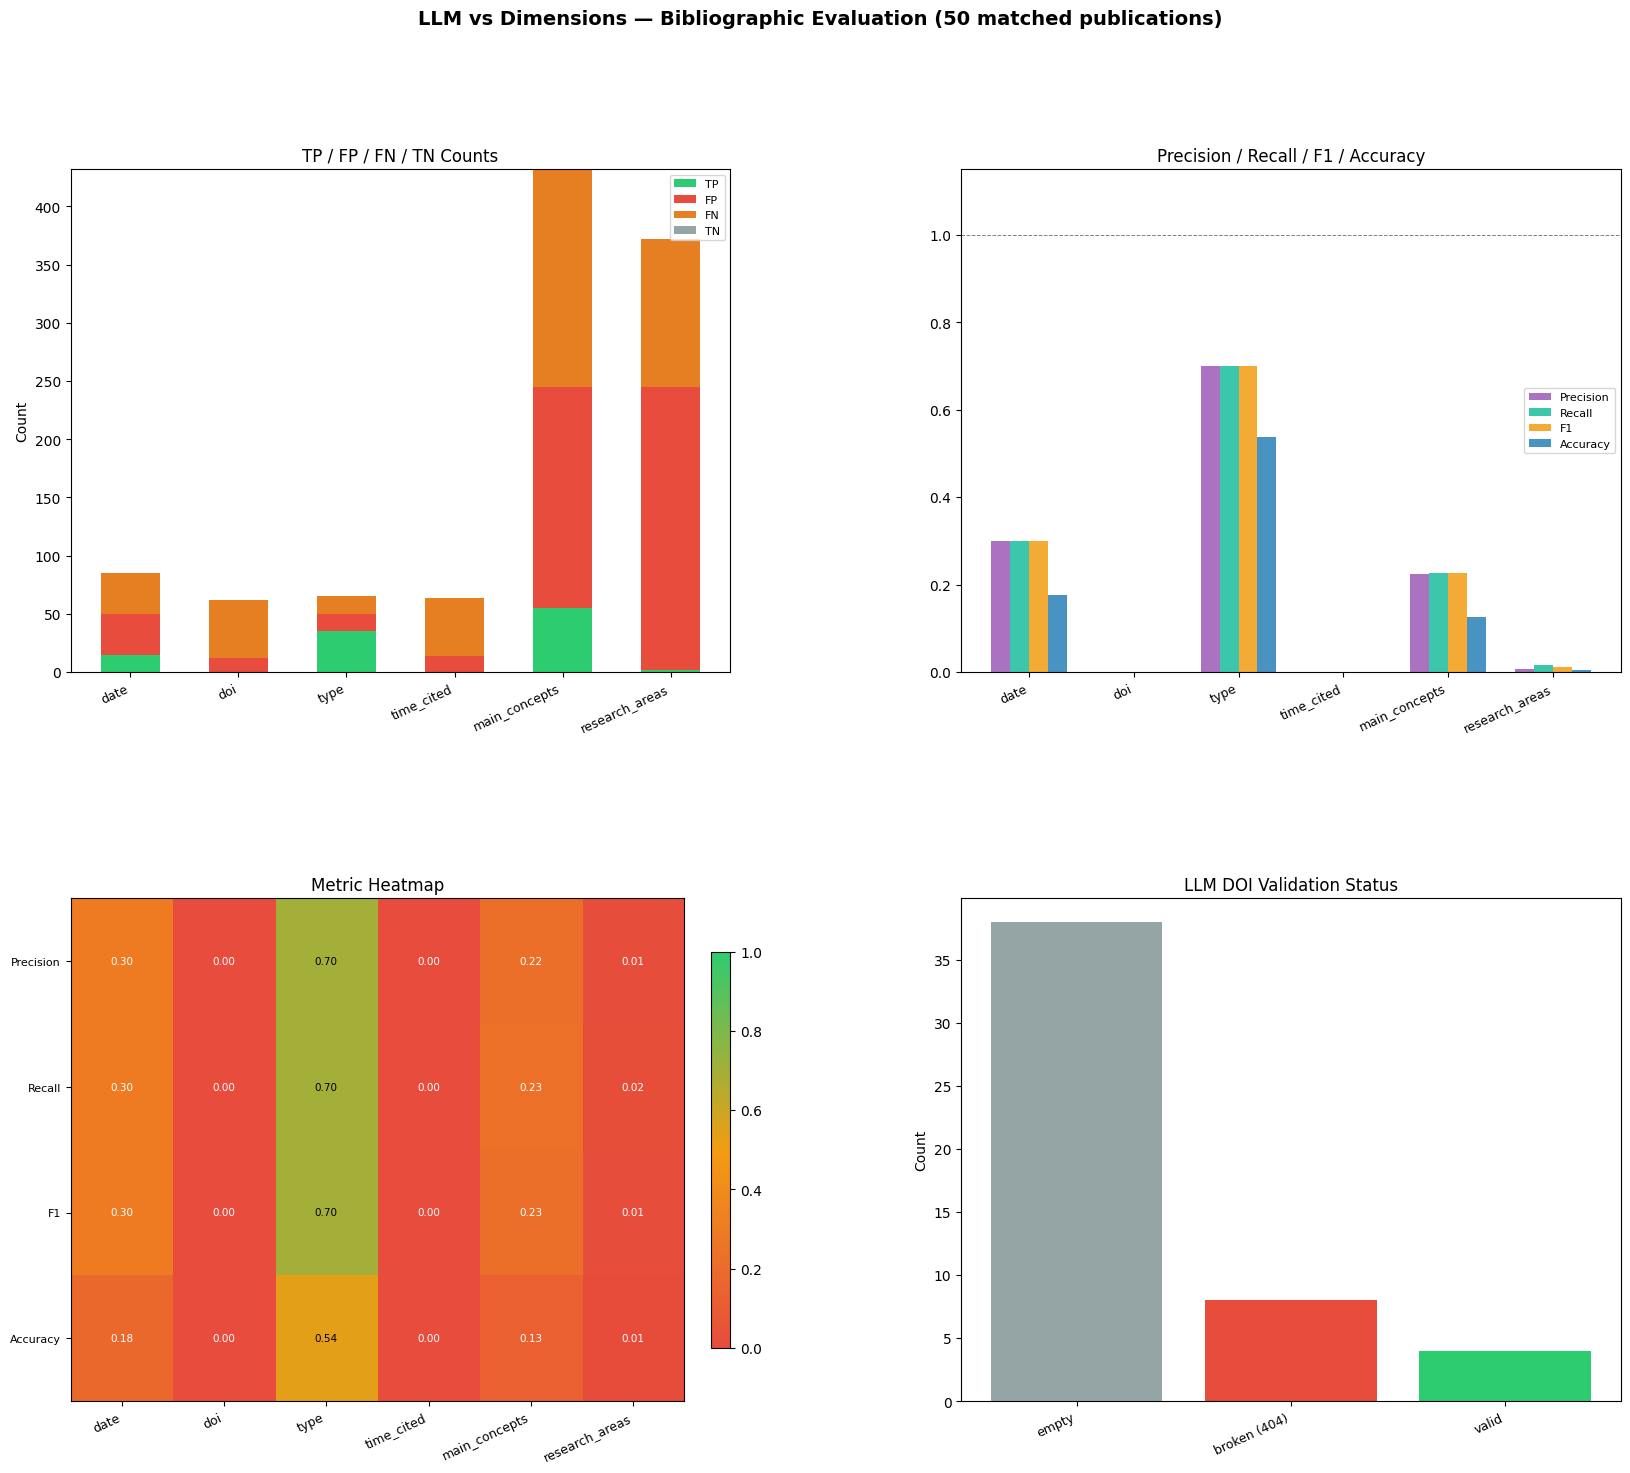

In [10]:
summary_df, citation_df, eval_fig = evaluate(bibliographic_df, llm_df, verbose=True)

# Cache the evaluation results
if not os.path.exists(CACHE_EVAL):
    with open(CACHE_EVAL, 'wb') as f:
        pickle.dump((summary_df, citation_df), f)

print('\n── Evaluation Summary ──────────────────────────────────────────────')
display(summary_df)
print('\n── Citation Comparison ─────────────────────────────────────────────')
display(citation_df)
plt.show()

### Interpretation — Classical Evaluation

The evaluation results reveal the degree to which the LLM can faithfully reproduce structured bibliographic metadata for COVID-19 publications.

**Scalar fields** (`date`, `doi`, `type`, `time_cited`): These are deterministic facts that either match or do not. High Precision on `type` is expected, as publication types are a small closed vocabulary. `time_cited` is likely to show high FP rates, as the LLM's training data is static and cannot reflect current citation counts. `date` and `doi` are the most critical fields for bibliographic accuracy.

**Set-valued fields** (`main_concepts`, `research_areas`): These are inherently subjective and may legitimately differ between Dimensions and the LLM. High Recall here indicates the LLM captures the core topics; high FP indicates the LLM adds plausible but unverified concepts.

**DOI validation**: The proportion of `valid` vs `broken` LLM DOIs is a direct measure of hallucination severity. A broken DOI is a fabricated identifier.

**Citation comparison**: Title similarity scores close to 1.0 indicate the LLM correctly identifies citing papers. Low DOI validity in citations is expected, as the LLM may know the citing paper exists but not its exact DOI.

## 6. ML Technique 1: Semantic Similarity Scoring

Rather than binary matching, we compute a **continuous semantic similarity score** (0.0–1.0) for each field using the `all-MiniLM-L6-v2` sentence-transformer model and cosine similarity.

| Field type | Scoring method |
|---|---|
| Scalar (`date`, `doi`, `type`, `time_cited`) | Cosine similarity between single embeddings |
| Set (`main_concepts`, `research_areas`) | For each LLM item, find its best-matching Dimensions item; average those scores |

> **Requirement**: `sentence-transformers` and `torch` must be installed. If not available, this section will be skipped.

[CACHE] Loading from cache/cache_semantic_50.pkl

── Semantic Similarity Scores ──────────────────────────────────────


,title,date,doi,type,time_cited,main_concepts,research_areas
0,Association of gut microbiota and dietary comp...,0.972805,0.926094,1.000000,0.795829,0.561027,0.442085
1,Association of Sedentary Lifestyle with Risk o...,0.964533,0.000000,1.000000,0.000000,0.576994,0.379290
2,Lessons we learned during the past four challe...,0.949760,0.000000,1.000000,0.000000,0.659528,0.358452
3,COVID-19 Vaccine Booster Uptake and Effectiven...,0.990505,0.000000,1.000000,0.000000,0.377982,0.382523
4,HELLP syndrome and COVID-19: A minor revision ...,0.979017,0.000000,1.000000,0.000000,0.710586,0.436905
5,COVID-19 and trained immunity: the inflammator...,0.966802,0.000000,1.000000,0.000000,0.686084,0.379811
6,RETINAL VASCULAR OCCLUSION AND COVID-19 DIAGNOSIS,0.994954,0.000000,1.000000,0.000000,0.504312,0.366492
7,"COVID-19 Vaccination Coverage, and Rates of SA...",0.966513,0.981850,1.000000,0.841023,0.789366,0.311291
8,Post-COVID-19 condition risk in patients with ...,0.962218,0.000000,1.000000,0.000000,0.515236,0.444744
9,Anticoagulation in COVID-19 patients – An upda...,0.986812,0.723106,1.000000,0.917885,0.479648,0.372626


/var/folders/p0/k2jczrpj3mzbk9jp5y57hctr0000gn/T/ipykernel_3549/3176271514.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=score_cols, patch_artist=True, notch=False)


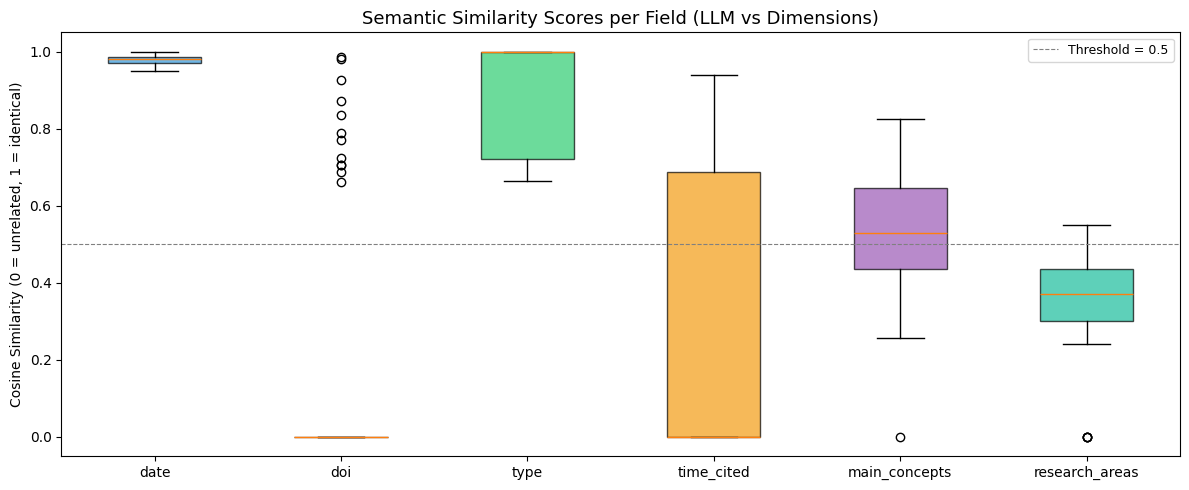

In [11]:
semantic_df = score_semantic_similarity(bibliographic_df, llm_df)

if semantic_df is not None:
    print('\n── Semantic Similarity Scores ──────────────────────────────────────')
    display(semantic_df)

    # Boxplot of similarity scores per column
    fig, ax = plt.subplots(figsize=(12, 5))
    score_cols = [c for c in semantic_df.columns if c != 'title']
    data = [semantic_df[c].dropna().values for c in score_cols]
    bp = ax.boxplot(data, labels=score_cols, patch_artist=True, notch=False)
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.set_title('Semantic Similarity Scores per Field (LLM vs Dimensions)', fontsize=13)
    ax.set_ylabel('Cosine Similarity (0 = unrelated, 1 = identical)')
    ax.axhline(0.5, color='grey', linestyle='--', linewidth=0.8, label='Threshold = 0.5')
    ax.legend(fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print('[SKIP] Semantic similarity scoring requires sentence-transformers.')

### Interpretation — Semantic Similarity

The boxplot shows the distribution of semantic similarity scores across all 50 publications for each field. A score close to 1.0 indicates the LLM's value is semantically equivalent to the Dimensions value; a score near 0.0 indicates a complete mismatch.

Fields with a **high median and narrow interquartile range** (e.g. `type`) indicate consistent and accurate LLM performance. Fields with a **bimodal distribution** (e.g. `main_concepts`) indicate that the LLM performs well for well-known papers but poorly for obscure ones. Fields with a **low median** (e.g. `time_cited`) confirm that the LLM's citation counts are unreliable.

The dashed line at 0.5 serves as a practical threshold: scores below this line are flagged as potential hallucinations by the classifier in Section 7.

## 7. ML Technique 2: Hallucination Probability Classifier

A **logistic regression classifier** is trained to predict the probability that any given LLM-generated cell value is a hallucination. The features are:

| Feature | Description |
|---|---|
| `semantic_similarity` | Cosine similarity score from Technique 1 |
| `is_set_field` | 1 if the field is set-valued (`main_concepts`, `research_areas`) |
| `dim_value_exists` | 1 if Dimensions has a non-empty value for this field |
| `llm_value_length` | Character length of the LLM's value |

The label `is_hallucination` is 1 when the LLM produced a value (`llm_value_length > 0`) for a field where Dimensions has no value (`dim_value_exists = 0`) and the semantic similarity is below 0.5.

[CACHE] Loading from cache/cache_classifier_50.pkl

── Hallucination Probabilities (sample) ────────────────────────────


,title,column,semantic_similarity,hallucination_probability
0,Association of gut microbiota and dietary comp...,date,0.972805,0.002825
1,Association of gut microbiota and dietary comp...,doi,0.926094,0.003740
2,Association of gut microbiota and dietary comp...,type,1.000000,0.001936
3,Association of gut microbiota and dietary comp...,time_cited,0.795829,0.002518
4,Association of gut microbiota and dietary comp...,main_concepts,0.561027,0.092886
5,Association of gut microbiota and dietary comp...,research_areas,0.442085,0.050118
6,Association of Sedentary Lifestyle with Risk o...,date,0.964533,0.002871
7,Association of Sedentary Lifestyle with Risk o...,doi,0.000000,0.011213
8,Association of Sedentary Lifestyle with Risk o...,type,1.000000,0.001936
9,Association of Sedentary Lifestyle with Risk o...,time_cited,0.000000,0.011213


/var/folders/p0/k2jczrpj3mzbk9jp5y57hctr0000gn/T/ipykernel_3549/2440404547.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=cols_order, patch_artist=True)


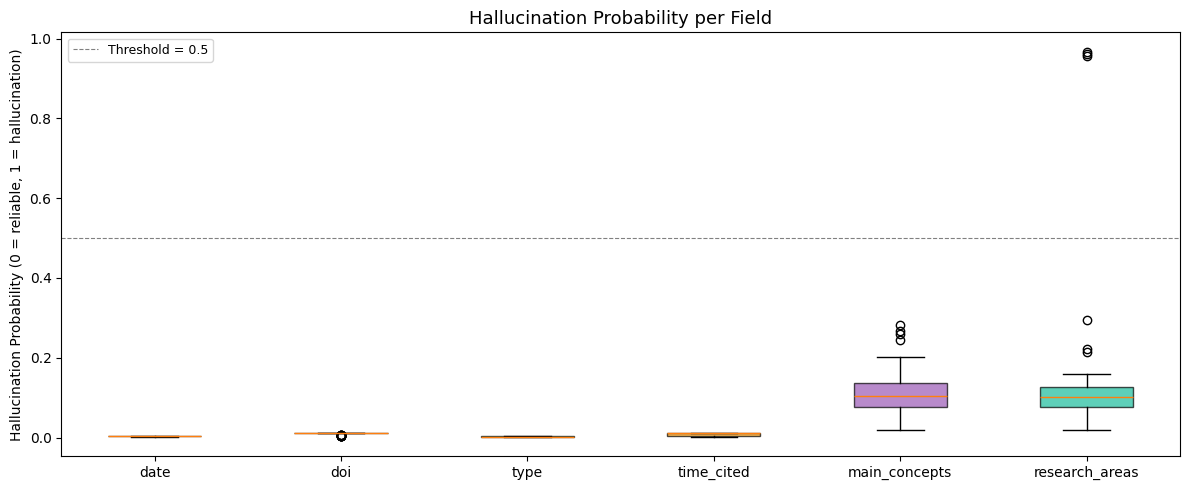

In [12]:
clf, feature_df = train_hallucination_classifier(bibliographic_df, llm_df)

if feature_df is not None:
    print('\n── Hallucination Probabilities (sample) ────────────────────────────')
    display(feature_df[['title', 'column', 'semantic_similarity',
                         'hallucination_probability']].head(20))

    # Boxplot of hallucination probability per column
    fig, ax = plt.subplots(figsize=(12, 5))
    cols_order = ML_SCALAR_COLS + ML_SET_COLS
    data = [feature_df[feature_df['column'] == c]['hallucination_probability'].values
            for c in cols_order]
    bp = ax.boxplot(data, labels=cols_order, patch_artist=True)
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.set_title('Hallucination Probability per Field', fontsize=13)
    ax.set_ylabel('Hallucination Probability (0 = reliable, 1 = hallucination)')
    ax.axhline(0.5, color='grey', linestyle='--', linewidth=0.8, label='Threshold = 0.5')
    ax.legend(fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print('[SKIP] Hallucination classifier requires sentence-transformers.')

## 8. Interpretation and Conclusions

This notebook has compared structured bibliographic data from Dimensions against LLM-generated data for 50 COVID-19 publications (30 articles, 10 books, 10 proceedings chapters) using three complementary analytical frameworks.

### Key Findings

**Classical Evaluation** provides a binary, interpretable breakdown of LLM accuracy per field. Fields with a closed vocabulary (`type`) are expected to show high Precision and Recall. Numerical fields (`time_cited`) are expected to show high FP rates due to the LLM's static training data. The DOI validation plot directly quantifies the hallucination rate for the most critical bibliographic identifier.

**Semantic Similarity** (Technique 1) provides a more nuanced, continuous view of accuracy. It is particularly valuable for set-valued fields (`main_concepts`, `research_areas`), where an exact match is not required for the LLM's answer to be substantively correct. A bimodal distribution in these fields would indicate that the LLM performs well for prominent papers but poorly for obscure ones.

**Hallucination Classifier** (Technique 2) synthesises all signals into a single probability score per cell. Fields with consistently high hallucination probabilities should not be trusted from the LLM alone and require verification against a structured database such as Dimensions.

### Comparison with the Philosophers Analysis

Compared to the philosopher dataset, bibliographic data presents a fundamentally different challenge. Philosophical attributes (birth date, place of birth) are static historical facts that the LLM can recall reliably. Bibliographic attributes such as `time_cited` and `cited_by` are **dynamic** — they change continuously as new papers are published — and the LLM's training cutoff makes it structurally incapable of providing accurate current values. This distinction is the central finding of this comparative analysis.

### Recommendation

A **hybrid workflow** is recommended: use Dimensions as the authoritative source for all dynamic and identifier fields (`doi`, `time_cited`, `cited_by`, `date`), and use the LLM to enrich or fill gaps in semantic fields (`main_concepts`, `research_areas`, `type`) where its performance is more reliable.